In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
y = pd.read_csv("/Users/bharatsingh/Downloads/Archive/AAPL_quarterly_financials.csv")

In [3]:
y.index = y.name

In [4]:
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:,:]

In [5]:
y.index = pd.to_datetime(y.index)

In [6]:
# CHECK IF NAS ARE NO DIVIDEND PERIOD
y = y.sort_index().fillna(0.)

# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data

In [7]:
from pytrends.request import TrendReq

In [8]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Online Sales Growth", "Consumer Spending Trends", "Job Openings", "Retail Foot Traffic", "E-commerce Performance", "Unemployment Rate Changes", "Funny Cat Videos", "Weather in Antarctica", "Historical Fashion Trends"]  
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [9]:
df = df.resample("Q").mean()
df = df.fillna(0)
X = df 
X = X[X.index.isin(y.index)]
y = y[y.index.isin(X.index)]


In [10]:
# ALIGN DATA
temp = pd.concat([y, X],axis = 1).dropna()
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()

# 3.) Normalize all the X data

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()

In [13]:
X_scaled = scaler.fit_transform(X)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [14]:
from sklearn.linear_model import Lasso

In [15]:
l = Lasso(alpha = 0.05)
l.fit(X_scaled, y)
Coefficients = l.coef_
Coefficients

array([ 0.        , -0.13737798, -0.2087988 ,  0.        ,  0.        ,
        0.14897651,  0.        ,  0.02773822, -0.        ])

In [16]:
import matplotlib.pyplot as plt

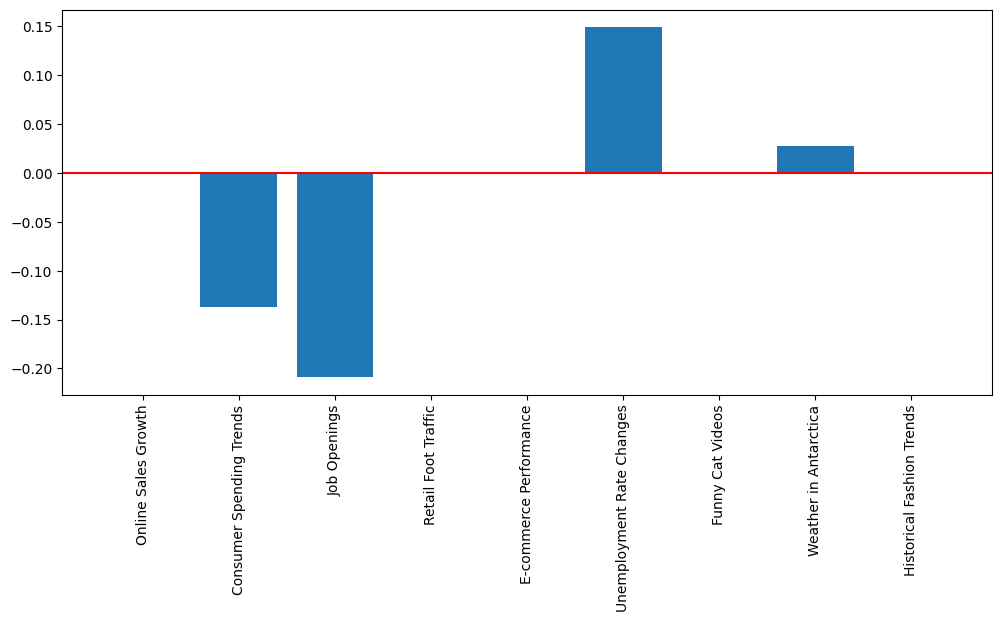

In [17]:
plt.figure(figsize = (12,5))
plt.bar(range(len(Coefficients)), Coefficients)
plt.xticks(range(len(Coefficients)), X.columns, rotation = 'vertical')
plt.axhline(0, color = "red")
plt.show()

# 5.) Do these coefficient magnitudes make sense?

#### Features with coefficients set to exactly zero indicate that these features are not contributing to the model. Lasso tends to select a subset of features and set the coefficients of less relevant features to zero.

Features with non-zero coefficients have an impact on the model. The sign of the coefficient indicates the direction of the relationship between the feature and the target variable. A positive coefficient suggests a positive correlation, while a negative coefficient suggests a negative correlation. The magnitude of the coefficients indicates the strength of the relationship between each feature and the target variable. 

The coefficients do make sense. 

#### Consumer Spending Trends and Job Openings have negative coefficients. This implies that an increase in these two features is associated with a decrease in the predicted target variable. In other words, higher consumer spending trends and job openings are associated with lower values of the target variable.

#### Unemployment Rate Changes and Weather in Antarctica have positive coefficients. This implies that an increase in these two features is associated with an increase in the predicted target variable. In other words, better rate and specific weather conditions in Antarctica are associated with higher values of the target variable.

#### Online Sales Growth, Funny Cat Videos, Historical Fashion Trends, and Retail Foot Traffic have coefficients set to exactly zero. This suggests that these features have been effectively excluded from the model, and they do not contribute to the prediction of the target variable.